# Setup and Imports

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set
import spacy
import nltk
from nltk.corpus import brown
from nltk.corpus import wordnet
from collections import Counter
import Tweet_Normalizer as tn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Load the Data

In [2]:
tweets = pd.read_csv("data/train.csv")

In [3]:
#View first few rows
pd.set_option('display.max_colwidth', 2)
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
#Check the dimensions
tweets.shape

(7613, 5)

# Clean and Normalize Tweets

In [5]:
%%time
#USe tweet scrubber function to clean the data
tweets = tn.tweet_scrubber(tweets, verbose = True)

Running tweet scrubber...

Dropping unnecessary columns
Successfully dropped columns!

Normalizing the tweets
Successfully normalized tweets!

Removing invalid and mispelled words
Successfully removed invalid and mispelled words!

Successfully scrubbed tweets!

Wall time: 2min 40s


In [6]:
#Check for blank rows after cleaning. We expect 5
tweets = tweets.replace(r'^(\s)+$', np.nan, regex = True)
tweets.isnull().sum()

text            0
target          0
Clean Tweets    5
dtype: int64

In [7]:
#Look at which rows are missing
tweets.loc[tweets["Clean Tweets"].isnull()]

,text,target,Clean Tweets
433,@local_arsonist LMFAO,0,NaN
820,Stats http://t.co/U7vavyrGv9,0,NaN
823,@Blizzard_Gamin ight,0,NaN
1858,@PYDisney que crush?#MTVHottest Justin Bieber,0,NaN
6957,@tsunami_esh ?? hey Esh,0,NaN


In [8]:
#Drop the empty rows
tweets.dropna(subset=["Clean Tweets"], inplace = True)

In [9]:
#Double check that the missing rows were actually dropped
tweets = tweets.replace(r'^(\s)+$', np.nan, regex = True)
tweets.isnull().sum()

text            0
target          0
Clean Tweets    0
dtype: int64

In [10]:
#Reset the index in place
tweets.reset_index(drop = True, inplace = True)

In [11]:
#Take a look at the last few rows of the data
tweets.tail(n=10)

,text,target,Clean Tweets
7598,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY,1,official say quarantine place alabama home possible ebola case develop symptom
7599,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1,fall g link tram update fire crew evacuate passenger
7600,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1,flip side I bomb evacuate stay tune I blow not
7601,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1,suicide bomber kill saudi security site mosque world google news wall
7602,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1,violent record break el reno oklahoma tornado nearly run
7603,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,two giant crane hold bridge collapse nearby home
7604,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,control wild fire california even northern part state troubling
7605,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,[ utc ] km volcano hawaii
7606,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,police investigate e bike collide car little portugal e bike rider suffer serious non life threaten injury
7607,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,1,late home raze northern california wildfire abc news


# Create Functions to Examine Tweet Details

In [12]:
def word_count(text):
    """
    This function counts the total words in the cleaned tweet
    
    test: String containing the text
    
    returns: Length of the text as an int

    """
    
    text = tn.word_tokenizer(text)
    
    return len(text)

In [13]:
nlp = spacy.load('en_core_web_sm')
def POS_counter(text, POS):
    """
    This function counts the POS tags in the text corpus and returns the total count
    
    text: String corpus
    
    returns: Number of POS in the tweet as int

    """
    text = nlp(text)
    POS_Count = 0
    
    
    for word in text:
        if word.pos_ == POS:
            POS_Count += 1
            
    return POS_Count

In [14]:
#Get the length of the clean tweets
tweets["Count"] = tweets["Clean Tweets"].apply(word_count)

In [15]:
%%time
#Get the count and proportion of the four main parts of speech (POS)
POS_lst = ["NOUN", "VERB", "ADJ", "ADV"]

for pos in POS_lst:
    tweets[pos] = tweets["Clean Tweets"].apply(POS_counter, POS = pos)
    pos_prop = pos + "_prop"
    tweets[pos_prop] = tweets[pos] / tweets["Count"]

Wall time: 4min 58s


In [18]:
#Explicity label the tweet as disaster or non-disaster(safe)
Tweet = ["Safe" if tweet == 0 else "Disaster" for tweet in tweets['target']]
#Add a new column based on target
tweets["Tweet"] = Tweet

In [19]:
tweets.head()

,text,target,Clean Tweets,Count,NOUN,NOUN_prop,VERB,VERB_prop,ADJ,ADJ_prop,ADV,ADV_prop,Tweet
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake may allah forgive,6,2,0.333333,3,0.500000,0,0.000000,0,0.0,Disaster
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la canada,5,3,0.600000,0,0.000000,0,0.000000,0,0.0,Disaster
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask shelter place notify officer no evacuation shelter place order expect,12,8,0.666667,2,0.166667,1,0.083333,0,0.0,Disaster
3,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfire evacuation order california,6,5,0.833333,1,0.166667,0,0.000000,0,0.0,Disaster
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got send photo ruby alaska smoke wildfire pour school,9,6,0.666667,2,0.222222,0,0.000000,0,0.0,Disaster


# Data Visualizations

## Percentage of Disaster and Safe Tweets

In [27]:
twt_df = pd.DataFrame(tweets["Tweet"].value_counts() / tweets.shape[0]).reset_index().rename(columns={"index": "Tweet", "Tweet": "Percentage"})
twt_df

,Tweet,Percentage
0,Safe,0.570058
1,Disaster,0.429942


Text(0.5, 0, 'Tweet Type')

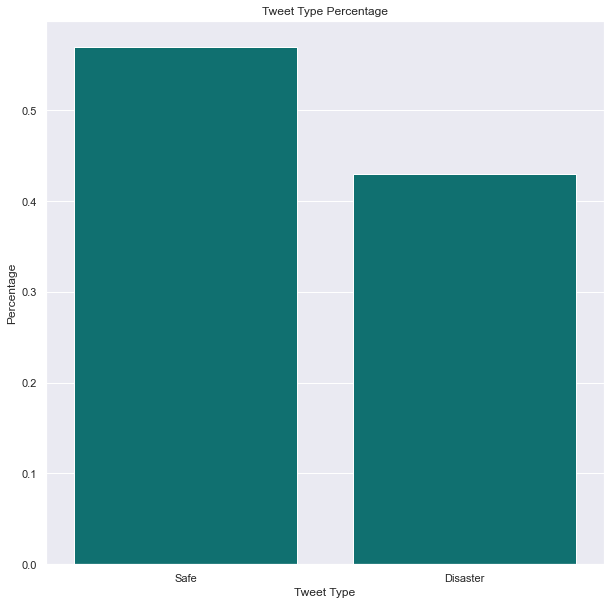

In [28]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.barplot(x="Tweet", y = "Percentage", data = twt_df, color = "teal")
plt.title("Tweet Type Percentage")
plt.ylabel("Percentage")
plt.xlabel("Tweet Type")

## Analyze Word Occurence

In [18]:
# Create a list of all words used in safe tweets
words = [word for row in tweets["Clean Tweets"] for word in row.split()]
# Create a counter to count the words
word_cnt = Counter(words)
# Create a dictionary of the words
word_dict = dict(word_cnt.most_common())
# Create a dataframe with words and their count
word_df = pd.DataFrame({"Word": word_dict.keys(), "Count": word_dict.values()})
# Create a new column with the word percentage
word_df["Percentage"] = (word_df["Count"] / len(words)) * 100
word_df.head(n=10)

,Word,Count,Percentage
0,I,2104,3.471833
1,not,754,1.244183
2,like,395,0.651794
3,get,375,0.618791
4,fire,359,0.592390
5,go,276,0.455431
6,no,266,0.438929
7,new,234,0.386126
8,u,218,0.359724
9,one,207,0.341573


Text(0.5, 1.0, 'Top 30 Words By Percentage')

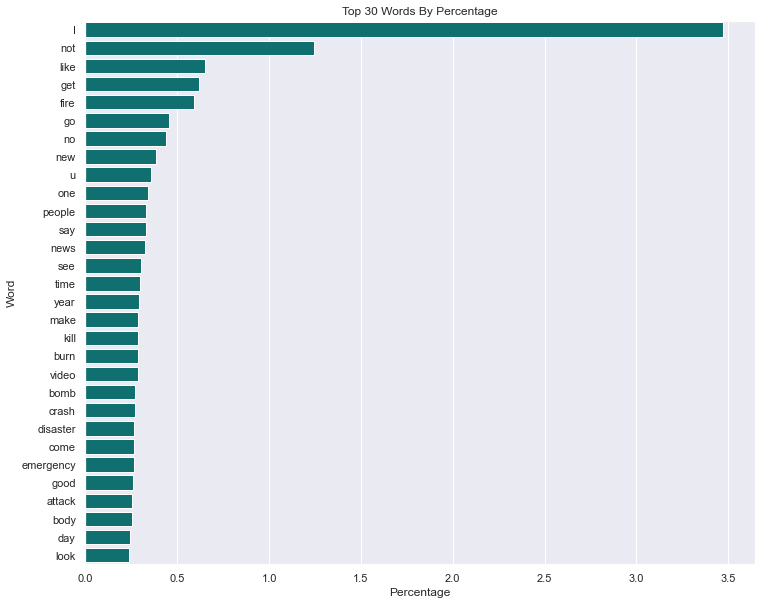

In [19]:
#Plot the top 30 words ranked by their percentage
sns.set(rc = {'figure.figsize':(12,10)})
sns.barplot(x="Percentage", y="Word", data = word_df[:30], color = "teal")
plt.title("Top 30 Words By Percentage")

### Analyze the distribution of word counts

In [20]:
word_grp_df = pd.DataFrame(word_df["Count"]\
                                           .value_counts()\
                                           .reset_index()\
                                           .rename(columns={"index": "Word Occurrence", "Count" :"Number of Words"}))\
                                            .sort_values(by="Word Occurrence")
word_grp_df[["Number of Words", "Word Occurrence"]]

,Number of Words,Word Occurrence
0,3257,1
1,1105,2
2,591,3
3,397,4
4,312,5
...,...,...
116,1,359
117,1,375
145,1,395
135,1,754


We see that the majority of words, 3,257, occurr are seen only once in the tweets. Let's take a look at what kinds of words these are. 

In [21]:
word_df.loc[word_df["Count"] == 1].head(n=20)

,Word,Count,Percentage
4236,notify,1,0.00165
4237,ruby,1,0.00165
4238,skiing,1,0.00165
4239,bridgetown,1,0.00165
4240,preaching,1,0.00165
4241,retainer,1,0.00165
4242,superintendent,1,0.00165
4243,deliberately,1,0.00165
4244,teammate,1,0.00165
4245,gunner,1,0.00165


## Analyze Word Occurence in Safe Tweets

### Analyze the most common words

In [22]:
# Create a list of all words used in safe tweets
safe_words = [word for row in tweets.loc[tweets["target"] == 0, "Clean Tweets"] for word in row.split()]
# Create a counter to count the words
safe_cnt = Counter(safe_words)
# Create a dictionary of the top 30 words
safe_dict = dict(safe_cnt.most_common())
# Create a dataframe with words and their count
safe_df = pd.DataFrame({"Word": safe_dict.keys(), "Count": safe_dict.values()})
# Create a new column with the word percentage
safe_df["Percentage"] = (safe_df["Count"] / len(safe_words)) * 100
safe_df.head(n=10)

,Word,Count,Percentage
0,I,1669,5.026654
1,not,536,1.614312
2,like,294,0.885462
3,get,270,0.813180
4,go,195,0.587296
5,new,172,0.518025
6,no,151,0.454778
7,one,138,0.415625
8,make,130,0.391531
9,see,129,0.388519


Text(0.5, 1.0, 'Top 30 Words By Percentage in Safe Tweets')

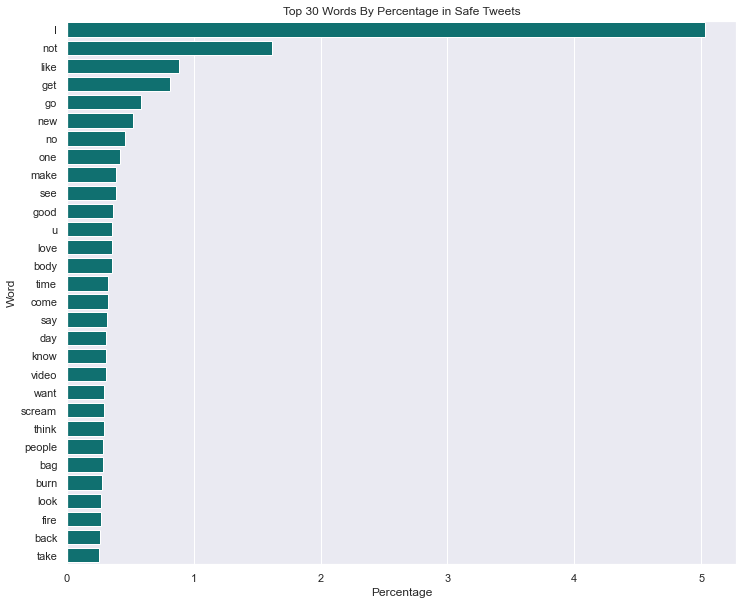

In [23]:
#Plot the top 30 words ranked by their percentage
sns.set(rc = {'figure.figsize':(12,10)})
sns.barplot(x="Percentage", y="Word", data = safe_df[:30], color = "teal")
plt.title("Top 30 Words By Percentage in Safe Tweets")

## Analyze Word Occurence in Disaster Tweets

### Analyze the most common words

In [24]:
disaster_words = [word for row in tweets.loc[tweets["target"] == 1, "Clean Tweets"] for word in row.split()]
disaster_cnt = Counter(disaster_words)
disaster_dict = dict(disaster_cnt.most_common())
disaster_df = pd.DataFrame({"Word": disaster_dict.keys(), "Count": disaster_dict.values()})
disaster_df["Percentage"] = (disaster_df["Count"] / len(disaster_words)) * 100
disaster_df.head(n = 10)

,Word,Count,Percentage
0,I,435,1.587649
1,fire,269,0.981788
2,not,218,0.795649
3,kill,156,0.569364
4,news,139,0.507318
5,disaster,122,0.445272
6,no,115,0.419723
7,bomb,113,0.412424
8,crash,112,0.408774
9,year,112,0.408774


Text(0.5, 1.0, 'Top 30 Words By Percentage in Disaster Tweets')

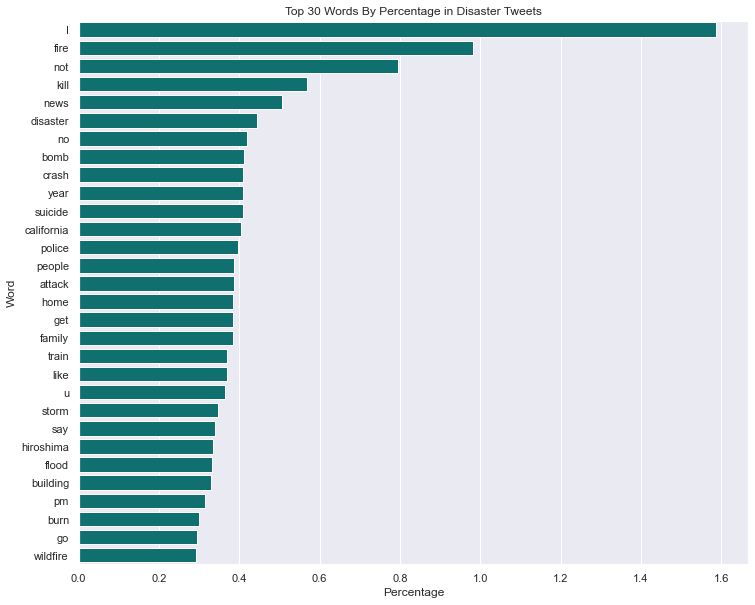

In [26]:
#Plot the top 30 words ranked by their percentage
sns.set(rc = {'figure.figsize':(12,10)})
sns.barplot(x="Percentage", y="Word", data = disaster_df[:30], color = "teal")
plt.title("Top 30 Words By Percentage in Disaster Tweets")

We see that the top few words for both safe and disaster tweets tend to be the same. However, they drastically change into words we'd expect to find in a disaster tweet and a safe tweet. 

## Analyze Tweet Length

In [39]:
twt_grp = tweets.groupby("Tweet")["Count"].aggregate(["mean", "std"]).sort_values(by="mean", ascending=False)
twt_grp

,mean,std
Tweet,,
Disaster,8.376338,3.134289
Safe,7.655983,3.575643


Text(0.5, 1.0, 'Length of Tweet By Tweet Type')

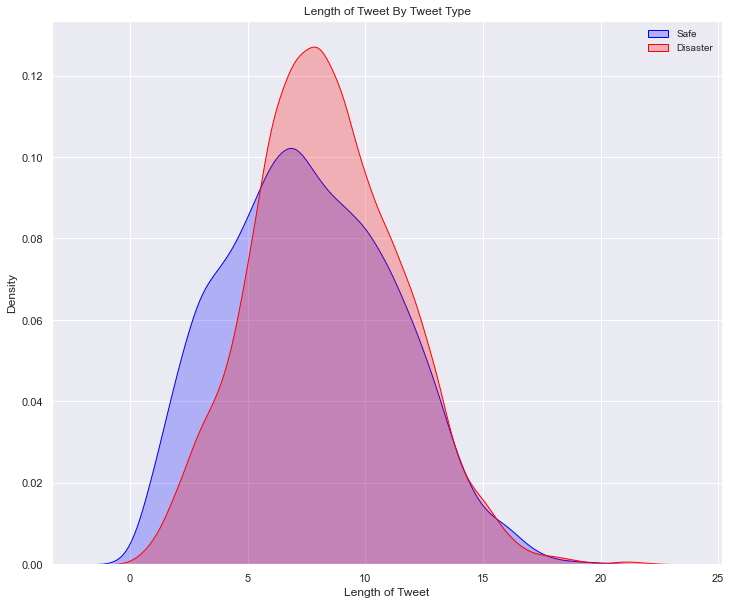

In [34]:
#Make a smoothed histogram showing the distribution of the number of words per tweet by tweet type
sns.set(rc = {'figure.figsize':(12,10)})
sns.kdeplot(tweets.loc[tweets["target"] == 0, "Count"], shade=True, color = 'blue')
sns.kdeplot(tweets.loc[tweets["target"] == 1, "Count"], shade=True, color = 'red')
plt.legend(["Safe", "Disaster"], frameon=False, fontsize='small')
plt.xlabel("Length of Tweet")
plt.title("Length of Tweet By Tweet Type")

We can see that on average, disaster tweets use more words per tweet than safe tweets. 

## Analyze Tweet Parts of Speech

To analyze the POS in each tweet, we'll look at the proportion by tweet. Therefore, we'll get an understanding on the POS structure for safe and disaster tweets. 

### Nouns

In [41]:
twt_noun_grp = tweets.groupby("Tweet")["NOUN_prop"].aggregate(["mean", "std"]).sort_values(by="mean", ascending=False)
twt_noun_grp

,mean,std
Tweet,,
Disaster,0.596703,0.191103
Safe,0.498370,0.236846


Text(0.5, 1.0, 'Proportion of Nouns By Tweet Type')

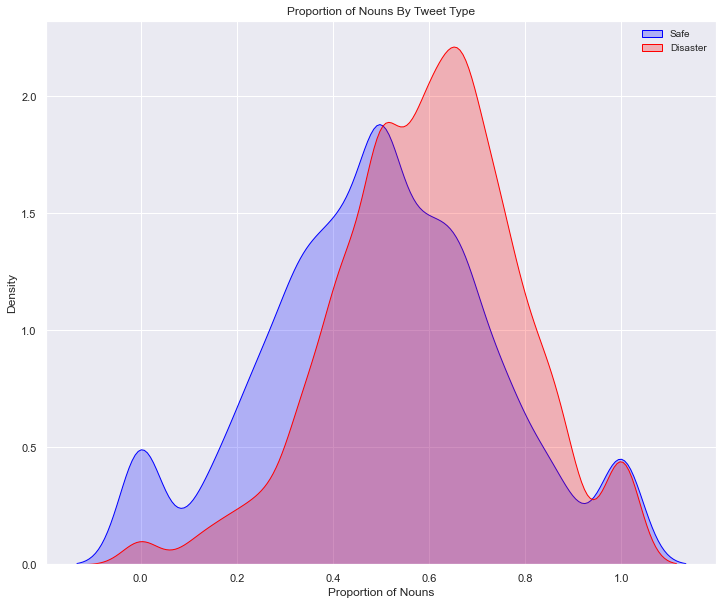

In [42]:
#Make a smoothed histogram showing the distribution of the number of words per tweet by tweet type
sns.set(rc = {'figure.figsize':(12,10)})
sns.kdeplot(tweets.loc[tweets["target"] == 0, "NOUN_prop"], shade=True, color = 'blue')
sns.kdeplot(tweets.loc[tweets["target"] == 1, "NOUN_prop"], shade=True, color = 'red')
plt.legend(["Safe", "Disaster"], frameon=False, fontsize='small')
plt.xlabel("Proportion of Nouns")
plt.title("Proportion of Nouns By Tweet Type")

### Verbs

In [43]:
twt_verb_grp = tweets.groupby("Tweet")["VERB_prop"].aggregate(["mean", "std"]).sort_values(by="mean", ascending=False)
twt_verb_grp

,mean,std
Tweet,,
Safe,0.200302,0.169855
Disaster,0.153447,0.127291


Text(0.5, 1.0, 'Proportion of Verbs By Tweet Type')

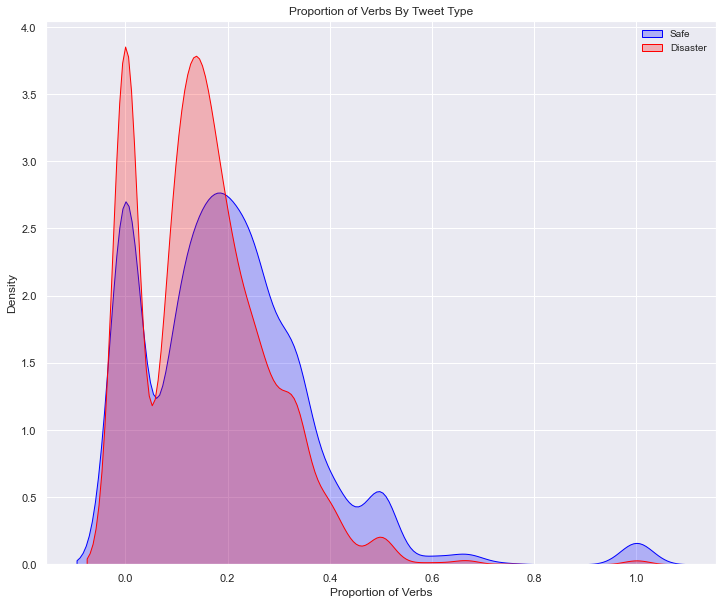

In [44]:
#Make a smoothed histogram showing the distribution of the number of words per tweet by tweet type
sns.set(rc = {'figure.figsize':(12,10)})
sns.kdeplot(tweets.loc[tweets["target"] == 0, "VERB_prop"], shade=True, color = 'blue')
sns.kdeplot(tweets.loc[tweets["target"] == 1, "VERB_prop"], shade=True, color = 'red')
plt.legend(["Safe", "Disaster"], frameon=False, fontsize='small')
plt.xlabel("Proportion of Verbs")
plt.title("Proportion of Verbs By Tweet Type")

### Adjectives

In [45]:
twt_verb_grp = tweets.groupby("Tweet")["ADJ_prop"].aggregate(["mean", "std"]).sort_values(by="mean", ascending=False)
twt_verb_grp

,mean,std
Tweet,,
Disaster,0.144536,0.130065
Safe,0.132262,0.143336


Text(0.5, 1.0, 'Proportion of Adjective By Tweet Type')

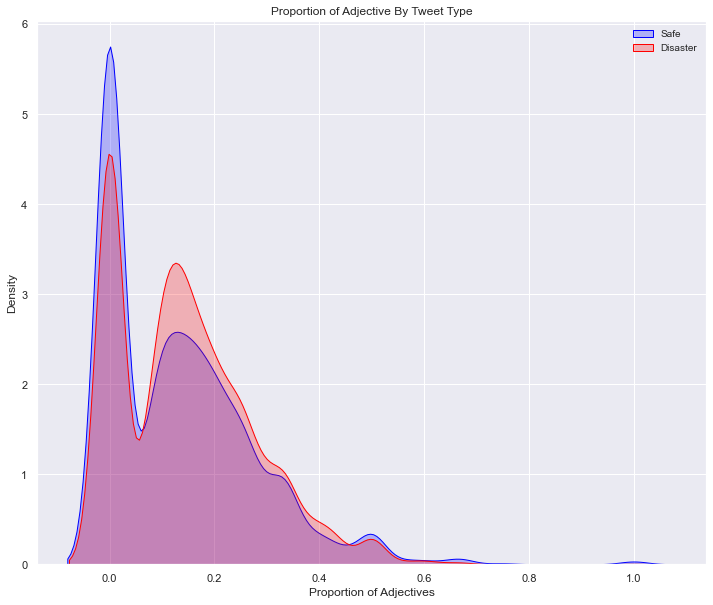

In [46]:
#Make a smoothed histogram showing the distribution of the number of words per tweet by tweet type
sns.set(rc = {'figure.figsize':(12,10)})
sns.kdeplot(tweets.loc[tweets["target"] == 0, "ADJ_prop"], shade=True, color = 'blue')
sns.kdeplot(tweets.loc[tweets["target"] == 1, "ADJ_prop"], shade=True, color = 'red')
plt.legend(["Safe", "Disaster"], frameon=False, fontsize='small')
plt.xlabel("Proportion of Adjectives")
plt.title("Proportion of Adjective By Tweet Type")

### Adverbs

In [47]:
twt_verb_grp = tweets.groupby("Tweet")["ADV_prop"].aggregate(["mean", "std"]).sort_values(by="mean", ascending=False)
twt_verb_grp

,mean,std
Tweet,,
Safe,0.041772,0.083561
Disaster,0.028132,0.065534


Text(0.5, 1.0, 'Proportion of Adverbs By Tweet Type')

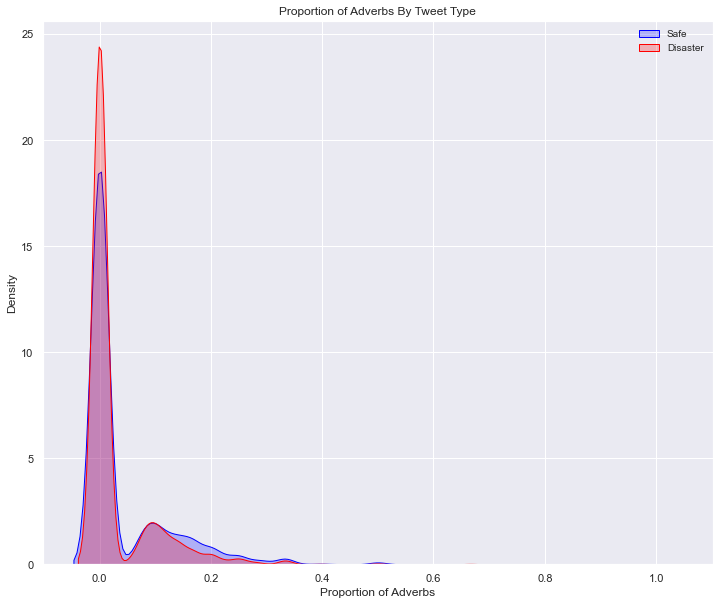

In [49]:
#Make a smoothed histogram showing the distribution of the number of words per tweet by tweet type
sns.set(rc = {'figure.figsize':(12,10)})
sns.kdeplot(tweets.loc[tweets["target"] == 0, "ADV_prop"], shade=True, color = 'blue')
sns.kdeplot(tweets.loc[tweets["target"] == 1, "ADV_prop"], shade=True, color = 'red')
plt.legend(["Safe", "Disaster"], frameon=False, fontsize='small')
plt.xlabel("Proportion of Adverbs")
plt.title("Proportion of Adverbs By Tweet Type")

### POS Comments

We see that safe and disaster tweets differ in the proportion of nouns and verbs that make up their tweets. Disaster tweets tend to have more nouns. Intuitively, this makes sense as disasters are typically things that take place at a location occur to some object. On the other hand, safe tweets are made up of slightly more verbs and have twice as many adverbs than disaster tweets. Finally, both tweets tend to have the same amount of adjectives. 

# Tweet Visualization Using t-SNE

In [22]:
cv = CountVectorizer(binary = False, min_df = 0.0, max_df = 1.0)
t_bow = cv.fit_transform(tweets["Clean Tweets"])

In [23]:
t_bow.shape

(7608, 7465)

In [26]:
t_bow

<7608x7465 sparse matrix of type '<class 'numpy.int64'>'
	with 55762 stored elements in Compressed Sparse Row format>

In [28]:
tsne = TSNE()
t_2D = tsne.fit_transform(t_bow)

In [31]:
t_2D.shape

(7608, 2)

In [34]:
t_2D[:, 0].shape

(7608,)

In [35]:
t_2D[:, 1].shape

(7608,)

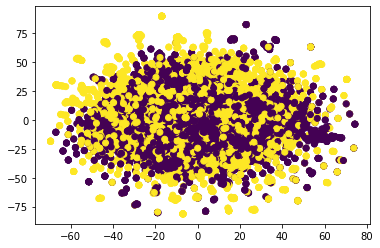

In [37]:
plt.scatter(t_2D[:, 0], t_2D[:, 1], c = tweets["target"])

In [ ]:
tsvd = TruncatedSVD(n_components=2)
t_50D = tsvd.fit_transform(t_bow)
t_2D = tsne.fit_transform(t_50D)

Text(0.5, 1.0, 't-SNE Visualization of Tweets')

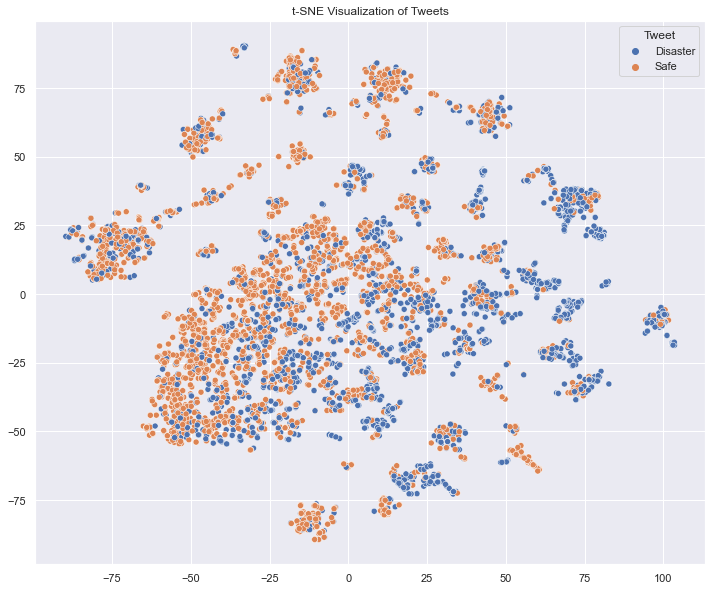

In [76]:
sns.set(rc = {'figure.figsize':(12,10)})
sns.scatterplot(x=t_2D[:, 0], y=t_2D[:, 1], hue = tweets["Tweet"])
plt.title("t-SNE Visualization of Tweets")